In [1]:
import tensorflow as tf
import os
import random
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())


Num GPUs Available:  0
False


In [2]:
SEED = 123456  
os.environ['PYTHONHASHSEED'] = str(SEED)  
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)  
np.random.seed(SEED)  
tf.random.set_seed(SEED) 

In [3]:
#carrega o conjunto de dados fashion mnist anteriormente utilizado e verificar se esta tudo dentro do esperado

from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()  # carrega os dados  
assert x_train.shape == (60000, 28, 28)  # verifica formato dos dados de treino  
assert x_test.shape == (10000, 28, 28)  # verifica formato dos dados de teste  
assert y_train.shape == (60000,)  # verifica formato dos rotulos de treino  
assert y_test.shape == (10000,)  # verifica formato dos rotulos de teste  

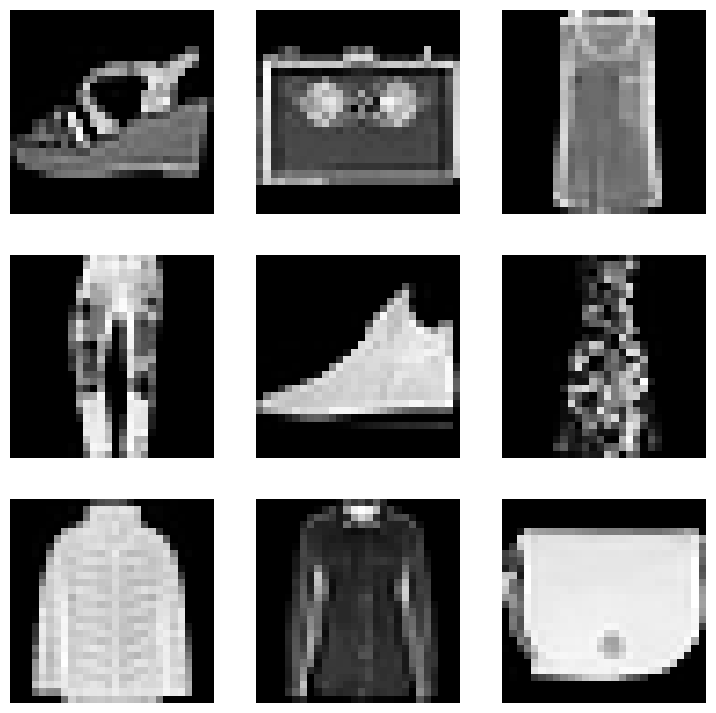

In [4]:
#pegar 9 amostras aleatorias para confimar se o dataset esta agindo de forma correta

import numpy as np  
from matplotlib import pyplot as plt 

plt.figure(figsize=(9, 9))  # define tamanho da figura  

rndSamples = np.random.choice(60000, 9)  # seleciona 9 amostras aleatorias  

for i in range(9):  
    plt.subplot(3,3,i+1)  # cria subplots 3x3  
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")  # exibe imagem em escala de cinza  
    plt.axis('off')  # oculta os eixos  

plt.show()    


In [5]:
#conjunto concatenado de teste e treino e adcionar um canal para a camada de convolucao (3 camadas)

dataset = np.concatenate([x_train, x_test], axis=0) # junta treino e teste
# Please note expand_dims converts images from 28x28 to 28x28x1
# Since convolutional layers expect 3 channels
dataset = np.expand_dims(dataset, -1).astype("float32") / 255 # adiciona canal e normaliza  

In [6]:
#aplica o truque de reparametrizacao

from tensorflow import keras
from tensorflow.keras import layers

# cria uma camada de amostragem
class SamplingLayer(layers.Layer):  
  """Truque de reparametrizacao z = mu + sigma * epsilon"""

  def call(self, inputs):  
    zMean, zLogVar = inputs  # recebe media e log variancia
    batch = tf.shape(zMean)[0]  # pega o tamanho do batch
    dim = tf.shape(zMean)[1]  # pega a dimensao do latente
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # amostra ruido normal
    return zMean + tf.exp(0.5 * zLogVar) * epsilon  # aplica reparametrizacao


In [7]:
# a funcao retornara um modelo keras a partir do encoder do modelo e depois instancia o mesmo 

def buildEncoder(latentDim, encoderInputs):

  # bloco convolucional que extrai caracteristicas das imagens
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),  # camada convolucional 1
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),  # camada convolucional 2
    layers.Flatten(),  # achatamento dos mapas de ativacao
    layers.Dense(256, activation="relu")  # camada densa para extracao de features
  ])

  # passa os inputs pelo bloco convolucional
  x = l1(encoderInputs)

  # camada dedicada para aprender a media da distribuicao
  zMean = layers.Dense(latentDim, name="z_mean")(x)

  # camada dedicada para aprender a variancia da distribuicao
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  # truque de reparametrizacao para obter z usando media e variancia
  z = SamplingLayer()([zMean, zLogVar])

  # modelo que recebe imagens e retorna media, variancia e distribuicao latente
  # zMean e zLogVar sao usados na perda de Kullback-Leibler (explicada abaixo)
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# instancia o modelo encoder com entradas de tamanho 28x28x1 e dimensao latente 2
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()  # exibe o resumo do modelo


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 256)               │         878,144 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │             514 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │             514 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sampling_layer                │ (None, 2)                 │               0 │ z_mean[0][0],              │
│ (SamplingLayer)               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#construcao do decoder, basicamente o oposto que fizemos anteriormente, fazendo uma transposicao 

def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),  # camada densa inicial
    layers.Reshape((7,7,64)),  # remodela para formato adequado para convolucao transposta
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),  # camada transposta 1
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),  # camada transposta 2
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")  # camada de saida, gera imagem reconstruida
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")  # retorna modelo do decodificador

# cria o modelo do decodificador com entradas de dimensao latente 2
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()  # exibe o resumo do modelo


C:\Users\Higor\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 1)           │         157,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#utiliza o KrossEntropy nos dados

def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),  # calcula a perda de entropia cruzada binária entre os dados e a reconstrução
          axis=(1, 2)  # soma a perda ao longo das dimensões espaciais da imagem (altura e largura)
      )
  )  # retorna a média das somas das perdas


In [10]:
#distribuicao de probabilidade dos dados originais x distribuicao de probabilidade a partir dos dados gerados

def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),  # calcula a divergência KL entre a distribuição normal padrão e a distribuição z
          axis=1  # soma ao longo da dimensão do batch
      )
  )  # retorna a média da divergência KL ao longo do batch


In [11]:
#calcula o total da loss juntando as duas funcoes anteriores, concatenando em apenas uma

def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)  # calcula a perda de reconstrução (erro entre dados originais e reconstruídos)
  loss2 = klDivergenceLoss(zMean, zLogVar)  # calcula a perda de divergência KL (medindo a diferença entre a distribuição aprendida e a normal padrão)
  klWeight = 3.0  # peso atribuído à perda de divergência KL
  return loss1, loss2, loss1 + klWeight * loss2  # retorna as duas perdas separadas e a perda total (soma ponderada da reconstrução e KL)


In [12]:
#basicamente cria um modelo personalizadoque codifica os dados, gera amostras latentes, 
#reconstroi a saida e otimiza os pesos minimizando a perda total

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)  # inicializa a classe base keras.Model
    self.encoder = encoder  # modelo encoder (para codificação de entrada)
    self.decoder = decoder  # modelo decoder (para reconstrução a partir do vetor latente)
    
    # inicializa as métricas que monitoram o progresso do modelo durante o treinamento
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")  # métrica de perda total
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")  # métrica de perda de entropia cruzada (reconstrução)
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")  # métrica de perda de divergência KL
    
  # Essa função define as métricas observáveis do modelo
  @property
  def metrics(self):
    return [
        self.totalLossTracker,  # inclui a perda total
        self.ceLossTracker,  # inclui a perda de entropia cruzada
        self.klLossTracker  # inclui a perda de divergência KL
    ]

  # Função de treinamento, que calcula a perda, calcula os gradientes e atualiza os pesos
  def train_step(self, data):
    # O GradientTape registra os gradientes necessários para atualizar os pesos treináveis
    with tf.GradientTape() as tape:
        # Passo direto: usa o encoder para gerar as representações latentes e o decoder para reconstruir os dados
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        # Calcula as perdas (reconstrução e divergência KL)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    
    # Passo reverso: calcula os gradientes a partir da perda total e aplica os gradientes para atualizar os pesos
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Atualiza as métricas com base nas perdas calculadas
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # Retorna os valores das métricas para o histórico de treinamento
    return {
        "total_loss": self.totalLossTracker.result(),  # perda total
        "ce_loss": self.ceLossTracker.result(),  # perda de entropia cruzada
        "kl_loss": self.klLossTracker.result()  # perda de divergência KL
    }


In [13]:
#treinando a vae, passando o modelo codificador e o decodificador

vae = VAE(encoder, decoder)  # cria uma instancia do modelo VAE com o encoder e decoder
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))  # compila o modelo com otimizador Adam e taxa de aprendizado de 0.001
history = vae.fit(dataset, epochs=32, batch_size=128)  # treina o modelo por 32 epocas com lote de 128 amostras


Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - ce_loss: 346.6029 - kl_loss: 2.9079 - total_loss: 355.3265
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - ce_loss: 266.3754 - kl_loss: 4.4900 - total_loss: 279.8454
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - ce_loss: 261.5811 - kl_loss: 4.6196 - total_loss: 275.4400
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - ce_loss: 259.4475 - kl_loss: 4.7014 - total_loss: 273.5519
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - ce_loss: 257.8632 - kl_loss: 4.7897 - total_loss: 272.2323
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - ce_loss: 256.9276 - kl_loss: 4.8297 - total_loss: 271.4168
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - ce_loss: 256.0022 - kl_loss: 4.9036 - total_loss: 270.7130
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - ce_loss: 255.2157 - kl_loss: 4.9390 - total_loss: 270.0327
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - ce_loss: 254.6726 - kl_l

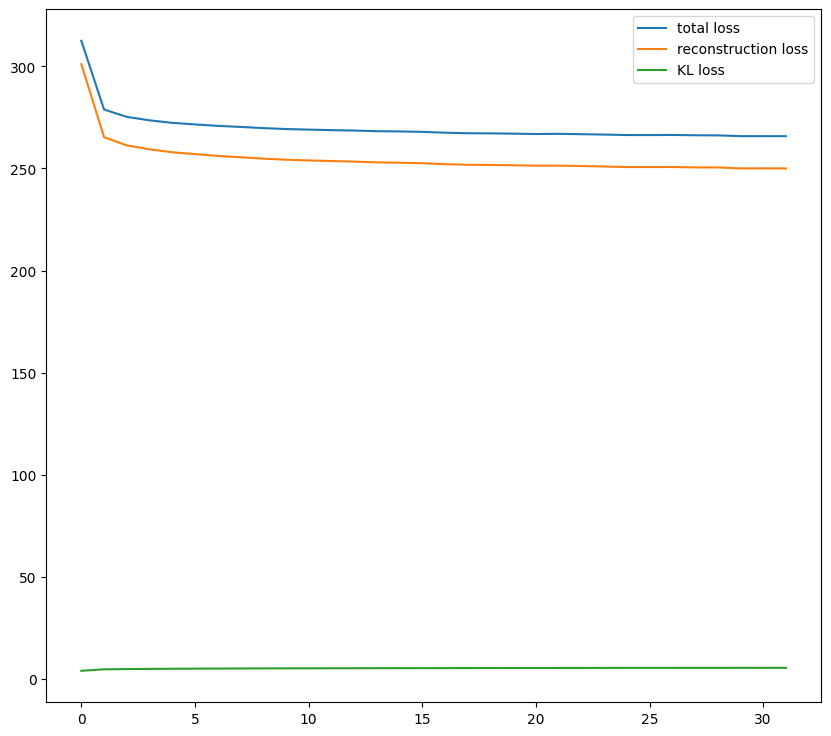

In [14]:
plt.figure(figsize=(10, 9))  # cria uma figura com tamanho de 10x9 polegadas
plt.plot(history.history.get('total_loss'), label="total loss")  # plota a curva de perda total ao longo das épocas
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")  # plota a curva de perda de reconstrução
plt.plot(history.history.get('kl_loss'), label="KL loss")  # plota a curva de perda KL
plt.legend()  # exibe a legenda no gráfico


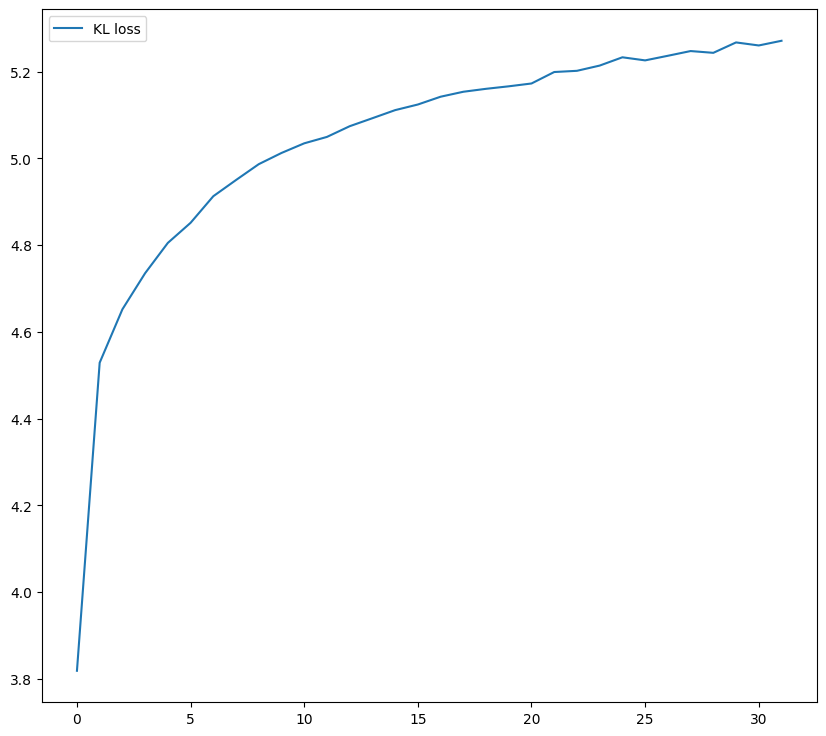

In [15]:
#plotando a kl, ja que no grafico anterior, por ser mto menor que a restante, fica dificil de visualziar

plt.figure(figsize=(10, 9))  # cria uma figura com tamanho de 10x9 polegadas
plt.plot(history.history.get('kl_loss'), label="KL loss")  # plota a curva da perda KL ao longo das épocas
plt.legend()  # exibe a legenda no gráfico


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


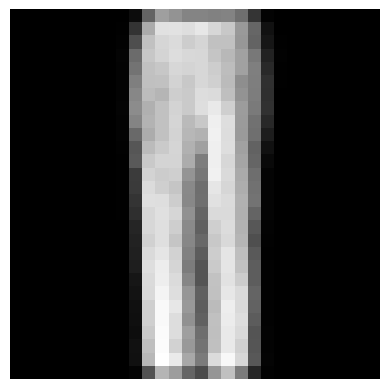

In [16]:
#vamos utilziar o decoder a aprtir de agora para reconstrucao de imagem paraq verificar se o treinameno funcionou


import numpy as np

# Converter para array numpy com a forma correta para o decoder (dimensão latente)
synth = vae.decoder.predict(np.array([[1, 2]]))  # garantindo que o input seja um array numpy com a forma correta

plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r")  # plota a imagem gerada


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


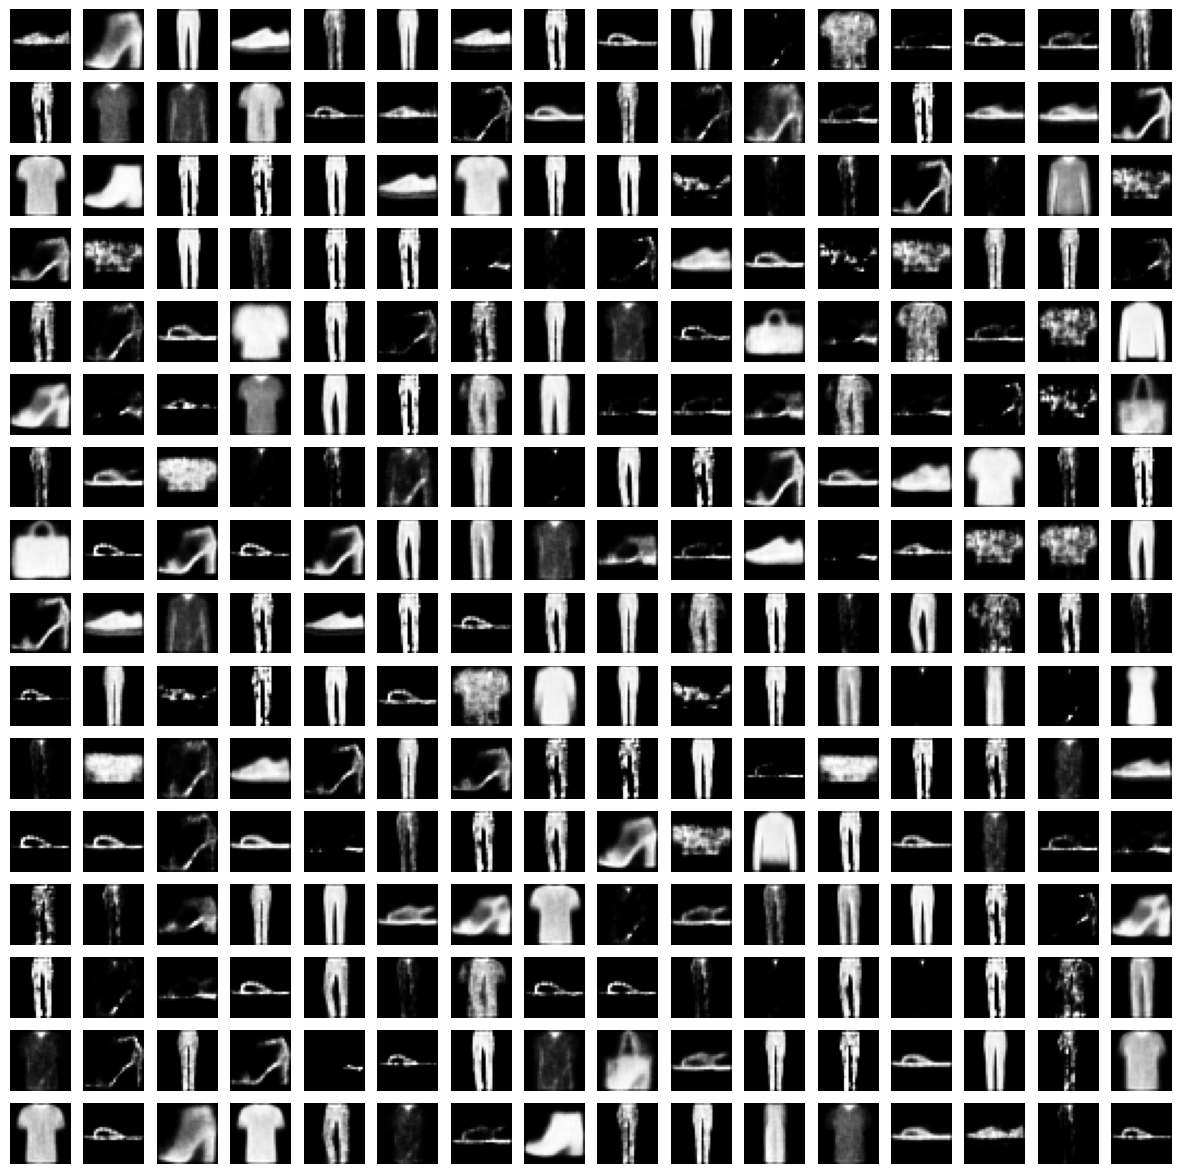

In [17]:
#mesma coisa que anteriormentem vamos utilziar o decoder para reconstrucao, mas agora para imagens aleatorias

z = np.random.normal(loc=0, scale=4, size=(256, 2))
synth = vae.decoder.predict(z)

# Usar figsize menor para não ficar grande demais
plt.figure(figsize=(15,15))

# Plotando 256 imagens em uma grid 16x16
for i in range(256):
    plt.subplot(16, 16, i + 1)
    plt.imshow(synth[i].reshape((28, 28)), cmap="Greys_r")
    plt.axis('off')

plt.show()


In [18]:
#verificar a distribuicao de probabilidade(media/variancia)

idx = 1280  # seleciona a imagem 1280 do conjunto de treino
batch = np.expand_dims(x_train[idx], axis=0)  # adiciona uma dimensao para que a imagem seja tratada como um lote
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255  # normaliza a imagem para o intervalo [0, 1] e adiciona dimensao do canal
print(batchOfImages.shape)  # imprime o formato da imagem

# obter z(mu,sigma) para a imagem dada
_, _, z = vae.encoder.predict(batchOfImages)  # passa a imagem pelo encoder para obter o vetor latente z

# agora reconstrua uma imagem similar
synth = vae.decoder.predict([z])  # usa o vetor latente z no decoder para gerar a imagem reconstruida

z  # imprime o vetor latente z


(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


C:\Users\Higor\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_10
Received: inputs=('Tensor(shape=(1, 2))',)
  warnings.warn(msg)


array([[0.27627718, 1.4311597 ]], dtype=float32)

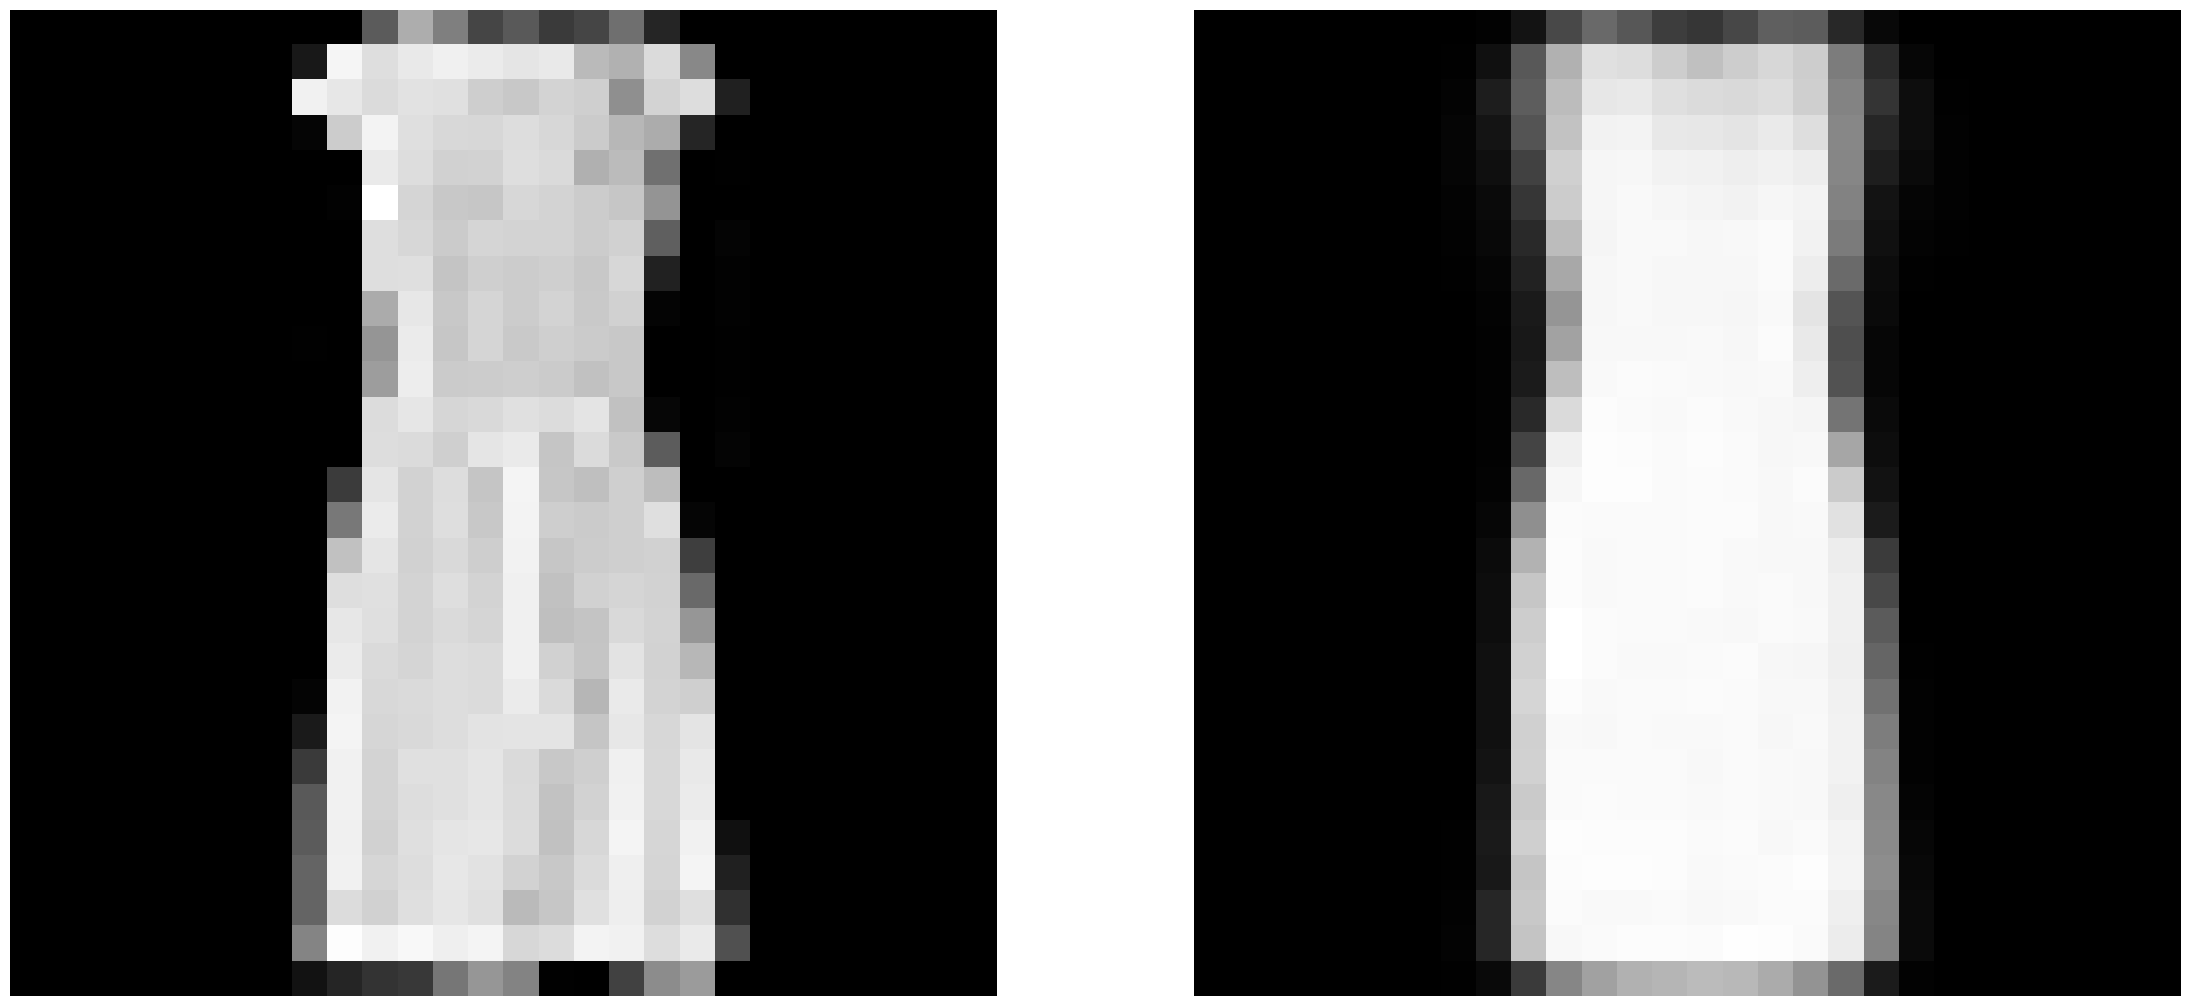

In [19]:
#sintetizar uma roupa em especifico e compara-la com a original

plt.figure(figsize=(28, 28))  # define o tamanho da figura, com 28x28 polegadas

# imagem original
plt.subplot(1,2,1)  # divide a figura em 1 linha e 2 colunas, seleciona o primeiro subplot
plt.axis('off')  # desliga os eixos
plt.imshow(x_train[idx], cmap="Greys_r")  # exibe a imagem original do indice 'idx' do conjunto de treino, usando o mapa de cores "Greys_r"

# imagem reconstruida
plt.subplot(1,2,2)  # seleciona o segundo subplot
plt.axis('off')  # desliga os eixos
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")  # exibe a imagem reconstruida pelo decoder, reshape para 28x28 e usa o mapa de cores "Greys_r"
plt.show()  # exibe a figura com as duas imagens


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


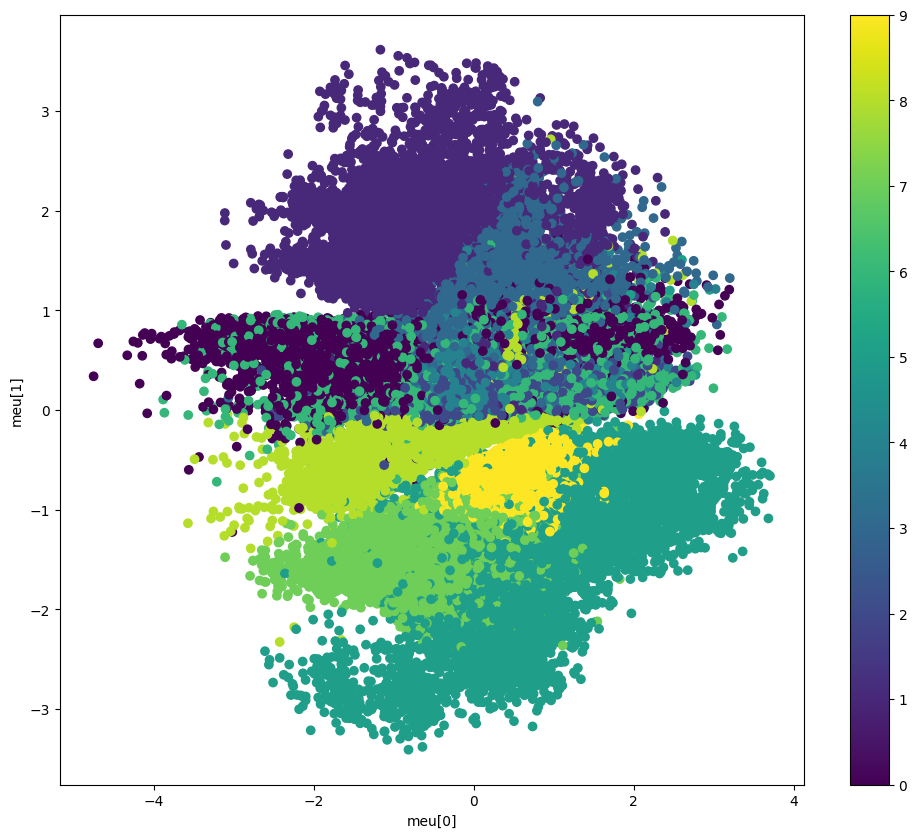

In [20]:
#visualizacao de probabilidade, plotando as medias e variancias em todo o conjunto de dados do encoder
#pintando com base nas categorias ja conhecidas, diferenciados as classificacoes

"""
VAE can be used in unsupervised learning of large text or unlabeled images corpus
to cluster the samples into categories
"""
labels = np.concatenate([y_train, y_test], axis=0)  # concatena os rótulos de treino e teste
meu, _, _ = vae.encoder.predict(dataset)  # gera os valores de media (mu) para cada amostra do dataset com o encoder
plt.figure(figsize=(12, 10))  # define o tamanho da figura
plt.scatter(meu[:, 0], meu[:, 1], c=labels)  # plota um gráfico de dispersão com as duas primeiras dimensões de 'meu', colorido pelos rótulos
plt.colorbar()  # adiciona uma barra de cores para indicar os valores dos rótulos
plt.xlabel("meu[0]")  # rótulo do eixo x
plt.ylabel("meu[1]")  # rótulo do eixo y
plt.show()  # exibe o gráfico